# Multi-Armed Bandits Exercises

These exercises are will help you gain a deeper understanding for the mechanisms and behavior\
of $\epsilon$-greedy action selection and sample-average based methods using k-armed bandit testbeds.

**NOTICE:**
1. You are allowed to work in groups of up to three people but **have to document** your group's\
 members in the top cell of your notebook.
2. **Comment your code**, explain what you do (refer to the slides). It will help you understand the topics\
 and help me understand your thinking progress. Quality of comments will be graded.
3. **Discuss** and analyze your results, **write-down your learnings**. These exercises are no programming\
 exercises it is about learning and getting a touch for these methods. Such questions might be asked in the\
 final exams.
 4. Feel free to **experiment** with these methods. Change parameters think about improvements, write down\
 what you learned. This is not only about collecting points for the final grade, it is about understanding\
  the methods.

#### Provided Code - The Bandit class

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class Bandit:

    def __init__(self):
        self.n_actions = 10
        # Action values q*(a) are selected according to a normal distribution N(0,1)
        #
        self._action_values = np.random.randn(self.n_actions)

    def action_space(self):
        # For the sake of efficiency, the action space will always be from 0 to n_actions-1.
        #
        return np.arange(self.n_actions)

    def take_action(self, action):
        assert action in self.action_space(), "invalid action selected, use action_space() to get a list of valid actions"

        # Actual rewards are selected according to a normal distribution N(mean(q*(At), 1)
        # Compute reward for this action.
        #
        reward = self._action_values[action] + 1 * np.random.randn(1)
        # Check if the optimal action was selected
        #
        is_optimal_action = np.isclose(self._action_values[action], self._action_values.max())
        return reward, is_optimal_action

    def action_values(self):
        # Returns the real action values.
        #
        return self._action_values

### Exercise 1: Estimating Action-Values

**Summary:**
In this exercise you will use the sample-averaging method to estimate action-values for a k-armed bandit.

**Provided Code:** Use the Bandit class from the cells above. Have a look at each method to figure out what it does.

**Your Tasks in this exercise:**

1. Implement the sample-averaging method.
2. Use your implementation to estimate the action-values of the bandit.
    * Compare your estimates with the real-values, how many iterations do you need?
    * Discuss and document your results and learnings.




In [25]:
# instantiate new bandit
bandit = Bandit()

In [26]:
# print out action values
print(bandit.action_values())
print(bandit.action_values().max())

[ 1.54294381 -0.77640009 -0.87190542  0.24419347  1.05836382  1.69416481
 -0.3828761   0.60517421  0.89472125 -1.90406854]
1.6941648060493943


In [ ]:
# create an agent that calculates sample averages with cycling through actions
class SampleAveragingAgent:

    def __init__(self, bandit, steps=1000):
        self.bandit = bandit
        self.steps = steps

        # count of how often each action was taken
        self.action_taken = np.zeros(bandit.n_actions)
        # total rewards for each action
        self.rewards = np.zeros(bandit.n_actions)
        # optimal action counts
        self.optimal_action_counts = np.zeros(steps)

    def run(self):
        for t in range(0, self.steps):
            # cycle through actions
            action = t % self.bandit.n_actions
            reward, is_optimal_action = self.bandit.take_action(action)

            # update count of times action was taken and total rewards
            self.action_taken[action] += 1
            self.rewards[action] += reward
            if is_optimal_action:
                self.optimal_action_counts[t] = 1

        # return average rewards
        return self.rewards / self.action_taken

C:\Users\nicok\AppData\Local\Temp\ipykernel_12840\3289141930.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.rewards[action] += reward


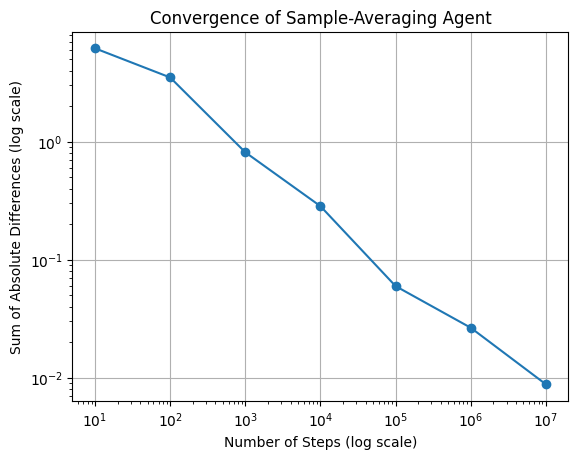

In [28]:
# run agent with different number of steps
steps = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
differences = []
for step in steps:
    saAgent = SampleAveragingAgent(bandit, steps=step)
    estimated_Q = saAgent.run()

    # sum up all differences between estimated and true action values
    diff = np.sum(np.abs(estimated_Q - bandit.action_values()))
    differences.append(diff)

# plot differences on a log-log scale
plt.plot(steps, differences, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Steps (log scale)')
plt.ylabel('Sum of Absolute Differences (log scale)')
plt.title('Convergence of Sample-Averaging Agent')
plt.grid(True)
plt.show()

### Results

It can be seen that the Sample Estimates for this problem-field is converging to the true action-values.
The decreasing error also shows that more steps equals a closer estimate to the real action values.

Deciding how many iterations are needed is hard, since it highly depends on how much accuracy is needed. Generally it can be said that more runs = more accuracy.

### Exercise 2 - $\epsilon$-greedy Action-Selection

**Summary:**
In this exercise you will use $\epsilon$-greedy action-selection with sample-averaging method to maximize the expected rewards in a k-armed bandit testbed.  

**Provided Code:** Use the ```Bandit``` class from the cells above. Have a look at each method to figure out what it does.


**Your Tasks in this exercise:**

1. Implement the sample-averaging method using $\epsilon$-greedy action-selection.
2. Use your implementation to select the best actions using $\epsilon$-greedy selection for 1000 time-steps.
    * Use different values for $\epsilon$, study the behavior.
    * Plot the average rewards over 200 different bandits for each value of $\epsilon$.
    * Plot the percentage (over 200 different bandits) how often the optimal action was selected at each time-step for each value of $\epsilon$.
    * Compare your results with the plot in the slides.
    * Discuss and document your results and learnings.


In [150]:
# create an agent that uses epsilon-greedy action selection with sample-averaging
class SampleAveragingEpsilonGreedyAgent:

    def __init__(self, bandit, epsilon, steps=1000):
        self.bandit = bandit
        self.epsilon = epsilon
        self.steps = steps

        # count of how often each action was taken
        self.action_taken = np.zeros(bandit.n_actions)
        # total rewards for each action
        self.rewards = np.zeros(bandit.n_actions)
        # estimated Q values
        self.estimated_Q_values = np.zeros(bandit.n_actions)

        # optimal action counts
        self.optimal_action_counts = np.zeros(steps)

        # we now also want to keep track of the reward history
        self.reward_history = np.zeros(steps)

    def run(self):
        for t in range(0, self.steps):
            # epsilon-greedy action selection
            if np.random.rand() < self.epsilon:
                # if random number is less than epsilon, explore
                action = np.random.choice(self.bandit.action_space())
            else:
                # else exploit
                action = np.argmax(self.estimated_Q_values)

            reward, is_optimal_action = self.bandit.take_action(action)

            # update count of times action was taken and total rewards
            self.action_taken[action] += 1
            self.rewards[action] += reward
            if is_optimal_action:
                self.optimal_action_counts[t] = 1

            # update estimated Q value for this action using the whole history instead of incremental (using that later)
            self.estimated_Q_values[action] = self.rewards[action] / self.action_taken[action]
            self.reward_history[t] = reward
            
        # return reward history and optimal action counts
        return self.reward_history, self.optimal_action_counts

C:\Users\nicok\AppData\Local\Temp\ipykernel_12840\99735766.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.rewards[action] += reward
C:\Users\nicok\AppData\Local\Temp\ipykernel_12840\99735766.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.reward_history[t] = reward


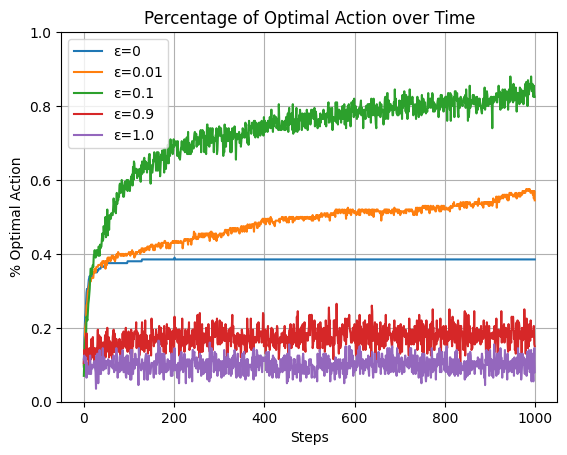

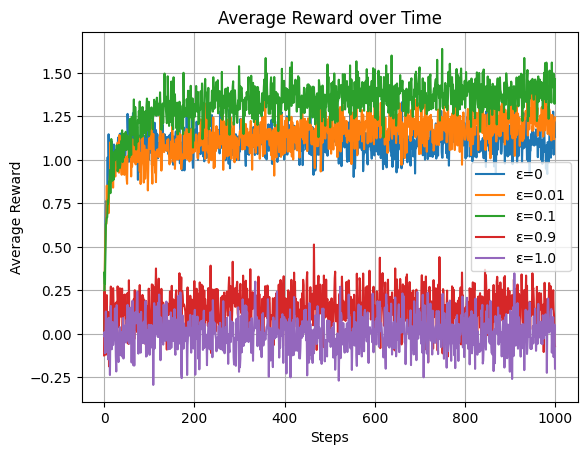

In [153]:
epsilon_values = [0, 0.01, 0.1, 0.9, 1.0]
average_rewards = {}
optimal_action_percentages = {}
count_different_bandits = 200

for epsilon in epsilon_values:
    # run multiple bandits and average results
    for _ in range(count_different_bandits):
        bandit = Bandit() # create a new bandit for new real action values
        agent = SampleAveragingEpsilonGreedyAgent(bandit, epsilon=epsilon, steps=1000)
        reward_history, optimal_actions = agent.run()
        average_rewards[epsilon] = average_rewards.get(epsilon, 0) + reward_history # sum up the estimated Q values on the dictionary
        optimal_action_percentages[epsilon] = optimal_action_percentages.get(epsilon, 0) + optimal_actions # sum up the optimal action counts on the dictionary


    # average the results over all bandits
    average_rewards[epsilon] /= count_different_bandits
    optimal_action_percentages[epsilon] /= count_different_bandits

# plot the optimal action percentages in y range [0,1]
plt.ylim(0, 1)
for epsilon, percentages in optimal_action_percentages.items():
    plt.plot(percentages, label=f'ε={epsilon}')
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.title('Percentage of Optimal Action over Time')
plt.legend()
plt.grid(True)
plt.show()

# plot the average reward
for epsilon, rewards in average_rewards.items():
    plt.plot(rewards, label=f'ε={epsilon}')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time')
plt.legend()
plt.grid(True)
plt.show()

### Result

It can be clearly seen that the runs with very high epsilon (here 0.9 and 1.0) just choose a random action to often and therefore average a low reward and a low percentage of optimal action taken. 
A epsilon of 1.0 is basically just guessing, so we just achieve about 10% optimal action choosen since we have a 1/10 chance to hit it. For a epsilon of 0.9 the percentage of optimal action choosen is a little higher since we have a 10% chance of taken the action we think is the best.

The algorithm with 0 epsilon achieves not to bad, but it will stick at the first best option, therefore the percentage in optimal actions taken plateus once it has fixed, for other algorithms with some kind of exploration (epsilon of 0.01 and 0.1) the percentage of optimal action taken still rises even after a longer time. It seems like a to small exploration could lead to very long time needed to find the best action.

The plots also look a lot like the plots in the slides just with more noise which could be caused by less bandits per epsilon on my runs as compared to the slide-plots.

### Exercise 3 - Nonstationary Bandit


**Summary:**
In this exercise you will implement a nonstationary k-armed bandit testbed and use the sample-averaging\
method on it.

**Provided Code:** None


**Your Tasks in this exercise:**

1. Extend the ```Bandit``` class such that the reward distributions are nonstationary. To do so:
    * Initialize all $q_*(a)$ to the same value.
    * On each step, take a step in an independent random walk for each action (you can do this by\
      adding a normally distributed value with mean 0 and standard devition of 0.01 to all $q_*(a)$\
      on each step).
2. Run the sample-averaging method with $\epsilon$-greedy action-selection using the nonstationary bandit.
    * Reproduce the plots from exercise 2 using the nonstationary bandit.
    * Interpret, discuss (and document) your results.

In [185]:
import numpy as np

# create a non-stationary bandit where the values of the action change over time by a random walk
class NonstationaryBandit:
    def __init__(self, n_actions=10, initial_value=0.0, step_mean=0.0, step_std=0.01):
        self.n_actions = n_actions

        # put all q*(a) to initial_value
        self._action_values = np.full(n_actions, initial_value)
        # set random walk parameters
        self.step_mean = step_mean
        self.step_std = step_std

    def action_space(self):
        return np.arange(self.n_actions)

    def take_action(self, action):
        assert action in self.action_space(), "invalid action selected, use action_space() to get a list of valid actions"

        # we do not need to noise the reward, since the q*(a) already change over time
        reward = self._action_values[action]

        # do a random walk step for all action values with given mean and std
        self._action_values += np.random.normal(self.step_mean, self.step_std, self.n_actions)

        # Check if optimal action
        is_optimal_action = np.isclose(self._action_values[action], self._action_values.max())

        return reward, is_optimal_action

    def action_values(self):
        return self._action_values

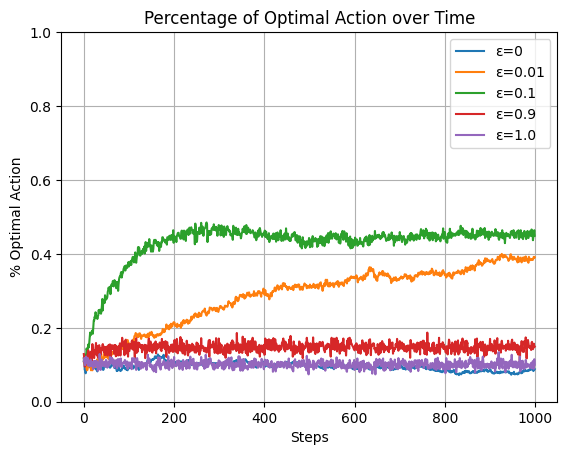

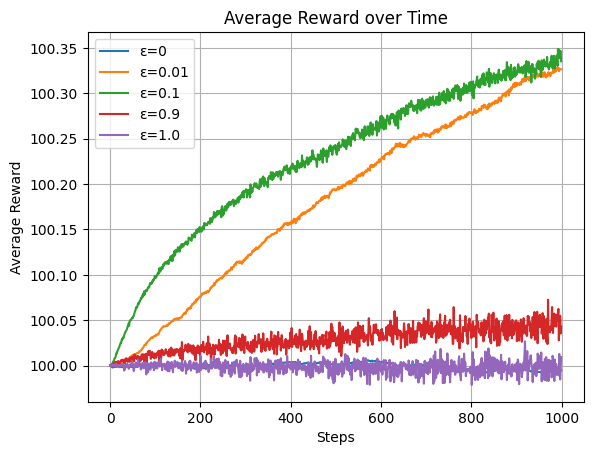

In [186]:
epsilon_values = [0, 0.01, 0.1, 0.9, 1.0]
average_rewards = {}
optimal_action_percentages = {}
count_different_bandits = 1000 # increased number of bandits for better averaging

for epsilon in epsilon_values:
    # run multiple bandits and average results
    for _ in range(count_different_bandits):
        nonStatBandit = NonstationaryBandit(10, 100.0, 0.0, 0.01) # create a new bandit for new real action values - this time non-stationary
        agent = SampleAveragingEpsilonGreedyAgent(nonStatBandit, epsilon=epsilon, steps=1000)
        reward_history, optimal_actions = agent.run()
        average_rewards[epsilon] = average_rewards.get(epsilon, 0) + reward_history # sum up the estimated Q values on the dictionary
        optimal_action_percentages[epsilon] = optimal_action_percentages.get(epsilon, 0) + optimal_actions # sum up the optimal action counts on the dictionary


    # average the results over all bandits
    average_rewards[epsilon] /= count_different_bandits
    optimal_action_percentages[epsilon] /= count_different_bandits

# plot the optimal action percentages in y range [0,1]
plt.ylim(0, 1)
for epsilon, percentages in optimal_action_percentages.items():
    plt.plot(percentages, label=f'ε={epsilon}')
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.title('Percentage of Optimal Action over Time')
plt.legend()
plt.grid(True)
plt.show()

# plot the average reward
for epsilon, rewards in average_rewards.items():
    plt.plot(rewards, label=f'ε={epsilon}')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time')
plt.legend()
plt.grid(True)
plt.show()

### Result

The biggest difference between these and the plots before is that the algorithm with a epsilon of 0 is doing very bad now, since it can not adapt at all if the optimal-action changes because of the random walk. 

Anyways also the algorithms with epsilon of 0.01 and 0.1 are doing worse than they did on the stationary bandit. it also looks like the best algorithm (epsilon 0.1) is now plateauing at a certain point. This basically could mean that because of the limited amount of exploration the algorithm can not pick up changes of optimal action that fast.

The algorithms with high exploration (epsilon of 0.9 and 1.0) seems like they did not change a lot. Since with epsilon 1.0 we are just always guessing and never pick a action we think is the best, it makes sense that the success rate did not change.
However it also looks like the epsilon of 0.9 is able to get "notified" about the change of the optimal action quicker but still has a high rate of non-optimal solutions because of high exploration.

### Exercise 4 - Average-Sampling with Constant Step-Size


**Summary:**
In this exercise you will use constant step-size sample-averaging to maximize the\
reward in a nonstationary k-armed bandit testbed.

**Provided Code:** None


**Your Tasks in this exercise:**

1. Implement the sample-averaging method using $\epsilon$-greedy action-selection with a constant step-size and incremental updates.
2. Use your implementation of the nonstationary bandit and your sample-averaging method with constant-step size\
   to select the best actions.
   * Use  $\epsilon = 0.1, \alpha=0.1$
   * Use more time-steps such as $10000$
   * Plot, discuss (and document) your results.